In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf
import pyemma
from pyemma.util.statistics import confidence_interval

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
import keras
import tensorflow as tf
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.training import FlexibleTrainer, MLTrainer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj

/Users/noe/anaconda/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.5, you have 2.5.3.
  .format(latest=latest, current=current), category=UserWarning)


In [6]:
def energy_stats(network):
    blind_sample_z, blind_sample_x, blind_energy_z, blind_energies_x, _ = network.sample(temperature=1.0, nsample=100000)
    nlow = np.size(np.where(blind_energies_x < 100)[0])
    return blind_energies_x.min(), nlow

def sample_stats(d):
    from deep_boltzmann.util import count_transitions, acf
    ntrans = count_transitions(d, 1.25, 1.75)
    acf100 = acf(d, 100)
    acf1000 = acf(d, 1000)
    acf10000 = acf(d, 10000)
    return ntrans, acf100[0], acf1000[0], acf10000[0]

def distance_metric(x):
    """ Outputs 2.5 for closed and 5 for open dimer
    """
    d = model.dimer_distance_tf(x)
    dscaled = 3.0 * (d - 1.5)
    return 2.5 * (1.0 + tf.sigmoid(dscaled))

In [7]:
def train_and_sample_free_energy(trainer, model, xtrain, temperatures_analysis, 
                                 nsample=100, nepochs_per_iter=10, niter=100, train_batchsize=None):
    bg = trainer.bg
    # Train and sample for multiple temperatures
    F_by_temp = [[] for T in temperatures_analysis]
    Ex_by_temp = [[] for T in temperatures_analysis]
    Jzx_by_temp = [[] for T in temperatures_analysis]
    for i in range(niter):  # training iteration
        print(i, '/', niter)
        if train_batchsize is None:
            trainer.train(xtrain, epochs=nepochs_per_iter)
        else:
            trainer.train(xtrain, epochs=nepochs_per_iter, batch_size=train_batchsize)
        for t, T in enumerate(temperatures_analysis):  # temperature iteration
            samples_z = np.sqrt(T) * np.random.randn(nsample, model.dim)
            samples_x, samples_Jzx = bg.transform_zxJ(samples_z)
            samples_enerx = model.energy(samples_x)
            Ex_by_temp[t].append(samples_enerx)
            Jzx_by_temp[t].append(samples_Jzx)     
    for t, T in enumerate(temperatures_analysis):  # temperature iteration
        F_by_temp[t] = np.concatenate(Ex_by_temp[t]) / T - np.concatenate(Jzx_by_temp[t])
        #Ex_by_temp[t] = np.concatenate(Ex_by_temp[t]) / T
        #Jzx_by_temp[t] = np.concatenate(Jzx_by_temp[t])
    return F_by_temp

In [8]:
def train_and_sample(trainer, model, xtrain, temperatures_analysis,
                     nsample=100, nepochs_per_iter=10, niter=100):
    bg = trainer.bg
    # Train and sample for multiple temperatures
    F_by_temp = [[] for T in temperatures_analysis]
    Ex_by_temp = [[] for T in temperatures_analysis]
    Jzx_by_temp = [[] for T in temperatures_analysis]
    Jxz_by_temp = [[] for T in temperatures_analysis]
    for i in range(niter):  # training iteration
        print(i, '/', niter)
        trainer.train(xtrain, epochs=nepochs_per_iter)
        for t, T in enumerate(temperatures_analysis):  # temperature iteration
            samples_z = np.sqrt(T) * np.random.randn(nsample, model.dim)
            samples_x, samples_Jzx = bg.transform_zxJ(samples_z)
            _, samples_Jxz = bg.transform_xzJ(samples_x)
            samples_enerx = model.energy(samples_x)
            Ex_by_temp[t].append(samples_enerx)
            Jzx_by_temp[t].append(samples_Jzx)
            Jxz_by_temp[t].append(samples_Jxz)
    for t, T in enumerate(temperatures_analysis):  # temperature iteration
        E = np.concatenate(Ex_by_temp[t])
        Jzx = np.concatenate(Jzx_by_temp[t])
        Jxz = np.concatenate(Jzx_by_temp[t])
        Ex_by_temp[t] = E
        Jzx_by_temp[t] = Jzx
        Jxz_by_temp[t] = Jxz
        F_by_temp[t] = E / T - Jzx
    resdict = {}
    resdict['E'] = Ex_by_temp
    resdict['Jzx'] = Jzx_by_temp
    resdict['Jxz'] = Jxz_by_temp
    resdict['F'] = F_by_temp
    return resdict

In [9]:
def dF_running_mean(dFs, window=100, step=1, dF_cut=50):
    dF_runningmean = []
    for i in range(0, dFs.size-window, step):
        chunk = dFs[i:i+window]
        chunk_reg = chunk[np.logical_and(chunk > -dF_cut, chunk < dF_cut)]
        dF_runningmean.append(chunk_reg.mean())
    return dF_runningmean

In [10]:
def clean_differences_from_scratch_chunk(E1, Jxz1, Jzx1, E2, Jzx2, Jxz2, T=1.0, chunksize=1000,
                                         cut_initial=-1000, cut_over_median=2500, cut_Jdiff=0.01, return_terms=False):
    dFs = []
    dEs = []
    dJs = []
    median1_cleaned = np.median(E1[E1 < cut_initial])
    median2_cleaned = np.median(E2[E2 < cut_initial])
    for t in range(0, E1.size//chunksize):
        E1chunk = E1[t*chunksize:(t+1)*chunksize]
        E2chunk = E2[t*chunksize:(t+1)*chunksize]
        Jzx1chunk = Jzx1[t*chunksize:(t+1)*chunksize]
        Jzx2chunk = Jzx2[t*chunksize:(t+1)*chunksize]
        Jxz1chunk = Jzx1[t*chunksize:(t+1)*chunksize]
        Jxz2chunk = Jzx2[t*chunksize:(t+1)*chunksize]
        # keep only what's good in both and where we have invertibility:
        sel_ener = np.logical_and(E1chunk < median1_cleaned + cut_over_median, 
                                  E2chunk < median2_cleaned + cut_over_median)
        sel_inv = np.logical_and(Jxz1chunk + Jzx1chunk < cut_Jdiff, Jxz2chunk + Jzx2chunk < cut_Jdiff)
        sel = np.logical_and(sel_ener, sel_inv)
        dF = np.mean((E2chunk[sel]/T - Jzx2chunk[sel]) - (E1chunk[sel]/T - Jzx1chunk[sel]))
        dE = np.mean(E2chunk[sel]/T - E1chunk[sel]/T)
        dJ = np.mean(Jzx1chunk[sel] - Jzx2chunk[sel])
        dFs.append(dF)
        dEs.append(dE)
        dJs.append(dJ)
    if return_terms:
        return np.array(dFs), np.array(dEs), np.array(dJs)
    else:
        return np.array(dFs)

In [11]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

Particle model
---
Run notebook "Particles_Simulation_Data" to generate data

In [12]:
# load trajectory data
trajdict = np.load('../data/particles_tilted/trajdata_long.npz')
import ast
params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [13]:
# create model
params['grid_k'] = 0.0
model = ParticleDimer(params=params)

In [14]:
# hyperparameters
hyperparams = {'layer_types' : 'RRRRRRRR',
               'nl_layers' : 3,
               'nl_hidden' : 200,
               'nl_activation' : 'tanh',
               'zstd' : 1.0,
               'reg_Jxz' : 0.0,
               'temperature' : [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0],
               'weight_ML' : 0.1,
               'weight_W2' : 0.0,
               'weight_RC' : 10.0,
               }

0.15 -60.78149494219376
0.15 -54.80906030006441
0.15 -66.82129157380976
0.25 -34.02408228190505
0.25 -36.378770183999876
0.25 -31.033689809728696
0.5 -14.286441470542922
0.5 -15.261248313620838
0.5 -13.63487889725406
1.0 -6.628717637498096
1.0 -7.124522164227016
1.0 -7.547679576558392
2.0 -3.3690130502955613
2.0 -3.298268077804168
2.0 -3.0709626368335443


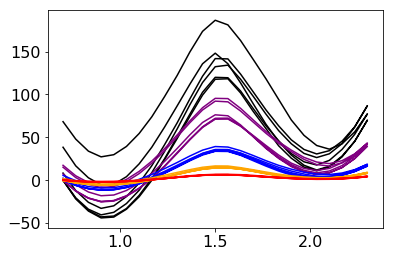

In [15]:
npzfile = np.load('./particles/US_data.npz')
colors = ['black', 'purple', 'blue', 'orange', 'red']
x = npzfile['umbrella_positions']
temperatures_US = npzfile['temperatures']
dF_closed_open_US = []
for i, dF in enumerate(npzfile['umbrella_free_energies']):
    icolor = i // 3
    plt.plot(x, dF, color=colors[icolor])
    W = np.exp(-dF)
    dF_at_kT0 = -np.log(np.sum(W[x < 1.5]) / np.sum(W[x >= 1.5]))
    dF_closed_open_US.append(dF_at_kT0)
    print(temperatures_US[i], dF_at_kT0)    

Boltzmann Generator
-------

In [16]:
ndata = 10000
batchsize_ML =  128
batchsize_KL = 1000
noise_intensity = 0.05

#ndata = 5000
#batchsize_ML =  128
#batchsize_KL = 1000
#noise_intensity = 0.05
temperatures_training = np.array([1.0, 2.0, 3.0])
temperatures_analysis = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.8, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0]

In [17]:
X1 = traj_closed_train[:ndata]
X1val = traj_closed_test[:ndata]
X1noise = X1 + noise_intensity * np.random.randn(*X1.shape).astype(np.float32)
X2 = traj_open_train[:ndata]
X2val = traj_open_test[:ndata]
X2noise = X2 + noise_intensity * np.random.randn(*X2.shape).astype(np.float32)

([], <a list of 0 Text yticklabel objects>)

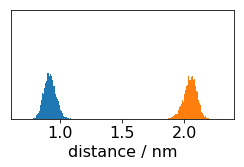

In [18]:
plt.figure(figsize=(4, 2))
X1_dist = model.dimer_distance(X1)
X2_dist = model.dimer_distance(X2)
plt.hist(X1_dist[X1_dist < 3], 100, density=True)
plt.hist(X2_dist[X2_dist < 3], 100, density=True)
plt.xlim(0.6, 2.4)
plt.ylim(0, 20)
plt.xticks([1, 1.5, 2])
plt.xlabel('distance / nm')
plt.yticks([])
#plt.savefig(paper_dir + 'figs/particles/minidist.pdf', bbox_inches='tight', transparent=True)

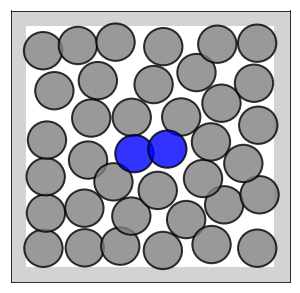

In [19]:
model.draw_config(X1[10], dimercolor='blue', alpha=0.8);

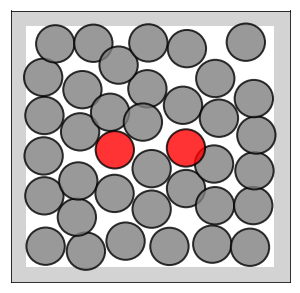

In [20]:
model.draw_config(X2[0], dimercolor='red', alpha=0.8);

In [21]:
bg1 = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=100, #100
             nl_activation='relu', nl_activation_scale='tanh', whiten=X1noise)
bg2 = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=100, #100
             nl_activation='relu', nl_activation_scale='tanh', whiten=X2noise)

W<RRRRRRRR>
W 76 0 0
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0
Instructions for updating:
Colocations handled automatically by placer.
21-04-19 23:40:11 tensorflow   WARNING  From /Users/noe/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
W<RRRRRRRR>
W 76 0 0
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0


In [22]:
hist_bg1_ML = bg1.train_ML(X1noise, xval=X1val, epochs=100, lr=0.001, batch_size=batchsize_ML, 
                           std=1.0, verbose=0, return_test_energies=False)
hist_bg2_ML = bg2.train_ML(X2noise, xval=X2val, epochs=100, lr=0.001, batch_size=batchsize_ML, 
                           std=1.0, verbose=0, return_test_energies=False)

Instructions for updating:
Use tf.cast instead.
21-04-19 23:40:14 tensorflow   WARNING  From /Users/noe/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


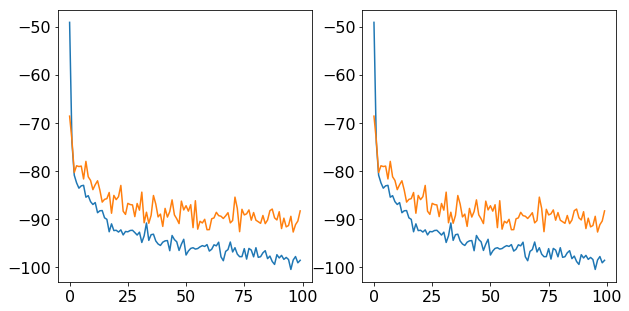

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(hist_bg1_ML[0])
axes[0].plot(hist_bg1_ML[1])
axes[1].plot(hist_bg1_ML[0])
axes[1].plot(hist_bg1_ML[1])
#axes[1].plot(mltrainer2.loss_train)

(0, 3)

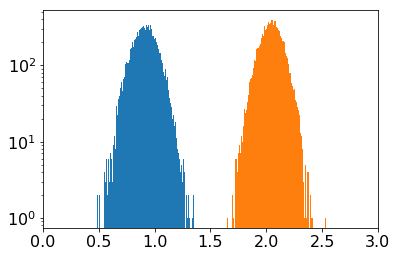

In [24]:
_, sample_x_bg1, _, energies_x_bg1, _ = bg1.sample(nsample=10000)
_, sample_x_bg2, _, energies_x_bg2, _ = bg2.sample(nsample=10000)
sample_d1 = model.dimer_distance(sample_x_bg1)
sample_d2 = model.dimer_distance(sample_x_bg2)
plt.hist(sample_d1[sample_d1 < 3], 100, log=True)
plt.hist(sample_d2[sample_d2 < 3], 100, log=True)
plt.xlim(0, 3)

**KL training**

In [25]:
# initial training
Eschedule = [[ 40,  0.0001, 1e6,  1e3,  0.0, 0.0],
             [ 40,  0.0001, 1e6,  300,  0.0, 0.0],
             [ 40,  0.0001, 1e5,  100,  0.0, 0.0],
             [ 40,  0.0001, 5e4,   50,  0.0, 0.0],
             [ 40,  0.0001, 5e4,   20,  0.0, 0.0],
             [100,  0.0001, 5e4,    5,  0.0, 0.0],
             [200,  0.0001, 5e4,    1,  0.0, 0.0]]

In [26]:
#Eschedule = [[200,  0.0001, 5e4,  0.5,  0.0, 0.0]]

In [27]:
resdicts1 = []
resdicts2 = []

In [28]:
for i, s in enumerate(Eschedule):
    print(s)
    flextrainer1 = FlexibleTrainer(bg1, lr=s[1], batch_size=batchsize_KL,
                                   high_energy=s[2], max_energy=1e10, temperature=temperatures_training,
                                   w_ML=s[3], w_KL=1.0, std=1.0)
    resdict = train_and_sample(flextrainer1, model, X1noise, temperatures_analysis, 
                               nsample=500, nepochs_per_iter=3, niter=s[0]//3)
    resdicts1.append(resdict)

[40, 0.0001, 1000000.0, 1000.0, 0.0, 0.0]
0 / 13
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
21-04-19 23:40:51 tensorflow   WARNING  From /Users/noe/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 0/3 loss 121686.5156 index_layer_3_loss -73.2880 lambda_51_loss 194974.5625 
Epoch 1/3 loss 128249.6172 index_layer_3_loss -67.1543 lambda_51_loss 195403.9062 
Epoch 2/3 loss 120646.1172 index_layer_3_loss -73.4968 lambda_51_loss 194142.9375 
1 / 13
Epoch 0/3 loss 124145.3984 index_layer_3_loss -73.6456 lambda_51_loss 197790.9531 
Epoch 1/3 loss 112731.9062 index_layer_3_loss -76.2630 lambda_51_loss 188994.8594 
Epoch 2/3 loss 114835.5000 index_layer_3_loss -72.0225 lambda_51_loss 186857.9844 
2 / 13
Epoch 0/3 loss 138473.9062 index_layer_3_loss -41.150

4 / 13
Epoch 0/3 loss -4987.5703 index_layer_3_loss -68.5507 lambda_51_loss 1867.4948 
Epoch 1/3 loss -5550.6489 index_layer_3_loss -69.7970 lambda_51_loss 1429.0494 
Epoch 2/3 loss -5300.7031 index_layer_3_loss -69.0572 lambda_51_loss 1605.0159 
5 / 13
Epoch 0/3 loss -5144.2407 index_layer_3_loss -70.3340 lambda_51_loss 1889.1636 
Epoch 1/3 loss -5389.9795 index_layer_3_loss -70.0589 lambda_51_loss 1615.9083 
Epoch 2/3 loss -5963.1323 index_layer_3_loss -74.8743 lambda_51_loss 1524.3003 
6 / 13
Epoch 0/3 loss -5870.9912 index_layer_3_loss -72.1773 lambda_51_loss 1346.7345 
Epoch 1/3 loss -5098.7764 index_layer_3_loss -67.8784 lambda_51_loss 1689.0646 
Epoch 2/3 loss -4442.0181 index_layer_3_loss -60.2758 lambda_51_loss 1585.5581 
7 / 13
Epoch 0/3 loss -2655.7507 index_layer_3_loss -40.4587 lambda_51_loss 1390.1218 
Epoch 1/3 loss -6093.8364 index_layer_3_loss -74.7386 lambda_51_loss 1380.0215 
Epoch 2/3 loss -5840.1670 index_layer_3_loss -75.3680 lambda_51_loss 1696.6321 
8 / 13
Epoch

Epoch 1/3 loss -961.8289 index_layer_3_loss -66.1375 lambda_51_loss 360.9214 
Epoch 2/3 loss -1026.5546 index_layer_3_loss -69.5285 lambda_51_loss 364.0164 
12 / 13
Epoch 0/3 loss -956.2526 index_layer_3_loss -65.8051 lambda_51_loss 359.8503 
Epoch 1/3 loss -1054.5181 index_layer_3_loss -70.0726 lambda_51_loss 346.9333 
Epoch 2/3 loss -1107.5161 index_layer_3_loss -73.3462 lambda_51_loss 359.4072 
[100, 0.0001, 50000.0, 5, 0.0, 0.0]
0 / 33
Epoch 0/3 loss -42.5267 index_layer_3_loss -73.4903 lambda_51_loss 324.9248 
Epoch 1/3 loss -26.2639 index_layer_3_loss -69.2196 lambda_51_loss 319.8344 
Epoch 2/3 loss -43.1565 index_layer_3_loss -71.5549 lambda_51_loss 314.6180 
1 / 33
Epoch 0/3 loss -52.9362 index_layer_3_loss -72.1440 lambda_51_loss 307.7838 
Epoch 1/3 loss -11.2583 index_layer_3_loss -69.5412 lambda_51_loss 336.4478 
Epoch 2/3 loss -27.7892 index_layer_3_loss -67.6743 lambda_51_loss 310.5822 
2 / 33
Epoch 0/3 loss -42.6957 index_layer_3_loss -72.9474 lambda_51_loss 322.0411 
Epo

Epoch 2/3 loss -51.6035 index_layer_3_loss -70.0965 lambda_51_loss 298.8793 
[200, 0.0001, 50000.0, 1, 0.0, 0.0]
0 / 66
Epoch 0/3 loss 219.4652 index_layer_3_loss -74.8153 lambda_51_loss 294.2805 
Epoch 1/3 loss 256.3416 index_layer_3_loss -68.7608 lambda_51_loss 325.1024 
Epoch 2/3 loss 257.0568 index_layer_3_loss -71.2375 lambda_51_loss 328.2943 
1 / 66
Epoch 0/3 loss 219.0661 index_layer_3_loss -71.6737 lambda_51_loss 290.7397 
Epoch 1/3 loss 228.1543 index_layer_3_loss -65.5748 lambda_51_loss 293.7291 
Epoch 2/3 loss 224.0832 index_layer_3_loss -65.0549 lambda_51_loss 289.1381 
2 / 66
Epoch 0/3 loss 224.8451 index_layer_3_loss -63.0177 lambda_51_loss 287.8628 
Epoch 1/3 loss 237.4631 index_layer_3_loss -58.4634 lambda_51_loss 295.9265 
Epoch 2/3 loss 290.3943 index_layer_3_loss -7.8944 lambda_51_loss 298.2887 
3 / 66
Epoch 0/3 loss 238.3808 index_layer_3_loss -74.4853 lambda_51_loss 312.8661 
Epoch 1/3 loss 225.9456 index_layer_3_loss -61.9421 lambda_51_loss 287.8877 
Epoch 2/3 los

34 / 66
Epoch 0/3 loss 208.5181 index_layer_3_loss -73.8248 lambda_51_loss 282.3428 
Epoch 1/3 loss 209.9828 index_layer_3_loss -70.6462 lambda_51_loss 280.6291 
Epoch 2/3 loss 208.2794 index_layer_3_loss -72.4636 lambda_51_loss 280.7431 
35 / 66
Epoch 0/3 loss 228.9754 index_layer_3_loss -68.4155 lambda_51_loss 297.3908 
Epoch 1/3 loss 213.8026 index_layer_3_loss -68.0638 lambda_51_loss 281.8664 
Epoch 2/3 loss 214.8579 index_layer_3_loss -71.8160 lambda_51_loss 286.6739 
36 / 66
Epoch 0/3 loss 277.1863 index_layer_3_loss -5.5732 lambda_51_loss 282.7596 
Epoch 1/3 loss 206.1434 index_layer_3_loss -75.3280 lambda_51_loss 281.4714 
Epoch 2/3 loss 217.1743 index_layer_3_loss -68.7129 lambda_51_loss 285.8872 
37 / 66
Epoch 0/3 loss 217.7737 index_layer_3_loss -64.9881 lambda_51_loss 282.7618 
Epoch 1/3 loss 209.2866 index_layer_3_loss -71.3995 lambda_51_loss 280.6861 
Epoch 2/3 loss 213.4191 index_layer_3_loss -67.4303 lambda_51_loss 280.8495 
38 / 66
Epoch 0/3 loss 212.1033 index_layer_3

In [29]:
for i, s in enumerate(Eschedule):
    print(s)
    flextrainer2 = FlexibleTrainer(bg2, lr=s[1], batch_size=batchsize_KL,
                                   high_energy=s[2], max_energy=1e10, temperature=temperatures_training,
                                   w_ML=s[3], w_KL=1.0, std=1.0)
    resdict = train_and_sample(flextrainer2, model, X2noise, temperatures_analysis, 
                               nsample=500, nepochs_per_iter=3, niter=s[0]//3)
    resdicts2.append(resdict)

[40, 0.0001, 1000000.0, 1000.0, 0.0, 0.0]
0 / 13
Epoch 0/3 loss 127154.2812 index_layer_9_loss -82.1849 lambda_103_loss 209339.1406 
Epoch 1/3 loss 142760.4844 index_layer_9_loss -60.2095 lambda_103_loss 202969.9844 
Epoch 2/3 loss 132511.0000 index_layer_9_loss -71.9911 lambda_103_loss 204502.1406 
1 / 13
Epoch 0/3 loss 110874.6797 index_layer_9_loss -90.0682 lambda_103_loss 200942.8594 
Epoch 1/3 loss 154369.7969 index_layer_9_loss -60.7425 lambda_103_loss 215112.2500 
Epoch 2/3 loss 124721.7422 index_layer_9_loss -71.8097 lambda_103_loss 196531.4219 
2 / 13
Epoch 0/3 loss 141908.9375 index_layer_9_loss -63.8845 lambda_103_loss 205793.4375 
Epoch 1/3 loss 113430.0234 index_layer_9_loss -73.6437 lambda_103_loss 187073.7500 
Epoch 2/3 loss 98640.3750 index_layer_9_loss -88.4593 lambda_103_loss 187099.7031 
3 / 13
Epoch 0/3 loss 100685.0938 index_layer_9_loss -85.0354 lambda_103_loss 185720.4531 
Epoch 1/3 loss 105690.2031 index_layer_9_loss -74.2172 lambda_103_loss 179907.4375 
Epoch 2

6 / 13
Epoch 0/3 loss -4603.7534 index_layer_9_loss -68.3910 lambda_103_loss 2235.3442 
Epoch 1/3 loss -6237.8535 index_layer_9_loss -82.6575 lambda_103_loss 2027.8937 
Epoch 2/3 loss -5723.8267 index_layer_9_loss -74.7534 lambda_103_loss 1751.5122 
7 / 13
Epoch 0/3 loss -4921.2368 index_layer_9_loss -67.8403 lambda_103_loss 1862.7920 
Epoch 1/3 loss -6058.6045 index_layer_9_loss -77.1789 lambda_103_loss 1659.2883 
Epoch 2/3 loss -5653.3755 index_layer_9_loss -72.1923 lambda_103_loss 1565.8531 
8 / 13
Epoch 0/3 loss -5313.1094 index_layer_9_loss -70.2115 lambda_103_loss 1708.0431 
Epoch 1/3 loss -6449.7598 index_layer_9_loss -80.3717 lambda_103_loss 1587.4095 
Epoch 2/3 loss -5164.5986 index_layer_9_loss -70.3942 lambda_103_loss 1874.8218 
9 / 13
Epoch 0/3 loss -5124.5000 index_layer_9_loss -67.1730 lambda_103_loss 1592.7960 
Epoch 1/3 loss -6337.7036 index_layer_9_loss -78.2230 lambda_103_loss 1484.5941 
Epoch 2/3 loss -5988.0059 index_layer_9_loss -76.1541 lambda_103_loss 1627.4052 


[100, 0.0001, 50000.0, 5, 0.0, 0.0]
0 / 33
Epoch 0/3 loss 260.4580 index_layer_9_loss -24.0169 lambda_103_loss 380.5425 
Epoch 1/3 loss 76.3804 index_layer_9_loss -70.6183 lambda_103_loss 429.4717 
Epoch 2/3 loss -24.2579 index_layer_9_loss -77.3936 lambda_103_loss 362.7102 
1 / 33
Epoch 0/3 loss 24.7612 index_layer_9_loss -69.9144 lambda_103_loss 374.3333 
Epoch 1/3 loss 94.7091 index_layer_9_loss -71.1366 lambda_103_loss 450.3919 
Epoch 2/3 loss 12.9102 index_layer_9_loss -71.7979 lambda_103_loss 371.8997 
2 / 33
Epoch 0/3 loss -27.0121 index_layer_9_loss -72.7687 lambda_103_loss 336.8313 
Epoch 1/3 loss -28.6599 index_layer_9_loss -69.6296 lambda_103_loss 319.4879 
Epoch 2/3 loss -36.0284 index_layer_9_loss -73.6244 lambda_103_loss 332.0934 
3 / 33
Epoch 0/3 loss 7.5269 index_layer_9_loss -65.6078 lambda_103_loss 335.5660 
Epoch 1/3 loss -32.0476 index_layer_9_loss -72.3805 lambda_103_loss 329.8551 
Epoch 2/3 loss 7.6531 index_layer_9_loss -71.0672 lambda_103_loss 362.9890 
4 / 33
E

1 / 66
Epoch 0/3 loss 214.2747 index_layer_9_loss -75.5457 lambda_103_loss 289.8205 
Epoch 1/3 loss 212.9290 index_layer_9_loss -76.5570 lambda_103_loss 289.4860 
Epoch 2/3 loss 219.3076 index_layer_9_loss -79.6368 lambda_103_loss 298.9445 
2 / 66
Epoch 0/3 loss 247.6317 index_layer_9_loss -47.4225 lambda_103_loss 295.0541 
Epoch 1/3 loss 212.2439 index_layer_9_loss -75.7981 lambda_103_loss 288.0420 
Epoch 2/3 loss 212.1127 index_layer_9_loss -78.6747 lambda_103_loss 290.7874 
3 / 66
Epoch 0/3 loss 230.2667 index_layer_9_loss -78.8233 lambda_103_loss 309.0900 
Epoch 1/3 loss 230.7923 index_layer_9_loss -74.4116 lambda_103_loss 305.2039 
Epoch 2/3 loss 224.1555 index_layer_9_loss -76.2651 lambda_103_loss 300.4207 
4 / 66
Epoch 0/3 loss 212.1006 index_layer_9_loss -78.7161 lambda_103_loss 290.8167 
Epoch 1/3 loss 212.3646 index_layer_9_loss -77.8267 lambda_103_loss 290.1913 
Epoch 2/3 loss 236.1746 index_layer_9_loss -71.1734 lambda_103_loss 307.3480 
5 / 66
Epoch 0/3 loss 231.4425 index

35 / 66
Epoch 0/3 loss 214.8215 index_layer_9_loss -70.9647 lambda_103_loss 285.7862 
Epoch 1/3 loss 211.6496 index_layer_9_loss -72.6797 lambda_103_loss 284.3293 
Epoch 2/3 loss 203.3772 index_layer_9_loss -79.2745 lambda_103_loss 282.6518 
36 / 66
Epoch 0/3 loss 206.9563 index_layer_9_loss -77.3653 lambda_103_loss 284.3216 
Epoch 1/3 loss 209.7154 index_layer_9_loss -73.6656 lambda_103_loss 283.3810 
Epoch 2/3 loss 206.5423 index_layer_9_loss -78.1024 lambda_103_loss 284.6447 
37 / 66
Epoch 0/3 loss 210.3602 index_layer_9_loss -77.2421 lambda_103_loss 287.6022 
Epoch 1/3 loss 215.0004 index_layer_9_loss -73.0802 lambda_103_loss 288.0807 
Epoch 2/3 loss 208.3832 index_layer_9_loss -74.8418 lambda_103_loss 283.2250 
38 / 66
Epoch 0/3 loss 230.3195 index_layer_9_loss -72.1678 lambda_103_loss 302.4873 
Epoch 1/3 loss 218.7399 index_layer_9_loss -74.8113 lambda_103_loss 293.5512 
Epoch 2/3 loss 210.6926 index_layer_9_loss -71.7879 lambda_103_loss 282.4805 
39 / 66
Epoch 0/3 loss 218.8491 

In [30]:
# concatenate results
swt_E1 = np.hstack([r['E'] for r in resdicts1])
swt_E2 = np.hstack([r['E'] for r in resdicts2])
swt_Jzx1 = np.hstack([r['Jzx'] for r in resdicts1])
swt_Jzx2 = np.hstack([r['Jzx'] for r in resdicts2])
swt_Jxz1 = np.hstack([r['Jxz'] for r in resdicts1])
swt_Jxz2 = np.hstack([r['Jxz'] for r in resdicts2])

/Users/noe/anaconda/lib/python3.5/site-packages/numpy/lib/histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


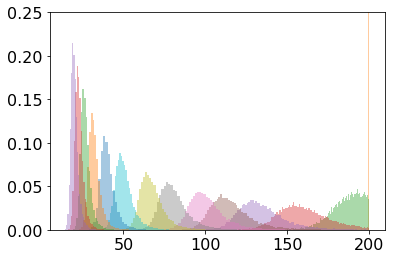

In [31]:
for t, T in enumerate(temperatures_analysis[:-4]):
    energies = swt_E1[i, -20000:] / T
    plt.hist(energies[energies<200], 100, density=True, alpha=0.4);
    plt.ylim(0, 0.25)

In [32]:
dFs12 = []
for t, T in enumerate(temperatures_analysis):
    dFs12.append(clean_differences_from_scratch_chunk(swt_E1[t], swt_Jzx1[t], swt_Jxz1[t], 
                                                      swt_E2[t], swt_Jzx2[t], swt_Jxz2[t], 
                                                      T=temperatures_analysis[t],                                            
                                                      #T=1.0,
                                                      chunksize=200, cut_initial=1000, cut_over_median=50))

/Users/noe/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/noe/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/noe/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


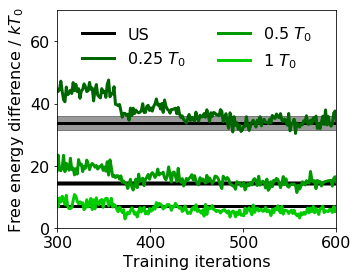

In [33]:
plt.figure(figsize=(5, 4))

xrange = np.linspace(0, 600, dFs12[0].size)

# Plot Umbrella sampling reference
#dF_true_015 = -np.mean(dF_closed_open_US[0:3])
dF_true_025 = -np.mean(dF_closed_open_US[3:6])
dF_true_05 = -np.mean(dF_closed_open_US[6:9])
dF_true_10 = -np.mean(dF_closed_open_US[9:12])
dF_true_20 = -np.mean(dF_closed_open_US[12:15])
#dF_true_015_std = np.std(dF_closed_open_US[0:3])
dF_true_025_std = np.std(dF_closed_open_US[3:6])
dF_true_05_std = np.std(dF_closed_open_US[6:9])
dF_true_10_std = np.std(dF_closed_open_US[9:12])
dF_true_20_std = np.std(dF_closed_open_US[12:15])
#plt.plot([xrange[0], xrange[-1]], [dF_true_015, dF_true_015], color='black', linewidth=3, label='Umbrella Sampling')
plt.plot([xrange[0], xrange[-1]], [dF_true_025, dF_true_025], color='black', linewidth=3, label='US')
plt.plot([xrange[0], xrange[-1]], [dF_true_05, dF_true_05], color='black', linewidth=3)
plt.plot([xrange[0], xrange[-1]], [dF_true_10, dF_true_10], color='black', linewidth=3)
#plt.plot([xrange[0], xrange[-1]], [dF_true_20, dF_true_20], color='black', linewidth=3)
#plt.fill_between([xrange[0], xrange[-1]], [dF_true_015-dF_true_015_std, dF_true_015-dF_true_015_std], [dF_true_015+dF_true_015_std, dF_true_015+dF_true_015_std], color='black', alpha=0.4)
plt.fill_between([xrange[0], xrange[-1]], [dF_true_025-dF_true_025_std, dF_true_025-dF_true_025_std], [dF_true_025+dF_true_025_std, dF_true_025+dF_true_025_std], color='black', alpha=0.4)
plt.fill_between([xrange[0], xrange[-1]], [dF_true_05-dF_true_05_std, dF_true_05-dF_true_05_std], [dF_true_05+dF_true_05_std, dF_true_05+dF_true_05_std], color='black', alpha=0.4)
plt.fill_between([xrange[0], xrange[-1]], [dF_true_10-dF_true_10_std, dF_true_10-dF_true_10_std], [dF_true_10+dF_true_10_std, dF_true_10+dF_true_10_std], color='black', alpha=0.4)
#plt.fill_between([xrange[0], xrange[-1]], [dF_true_20-dF_true_20_std, dF_true_20-dF_true_20_std], [dF_true_20+dF_true_20_std, dF_true_20+dF_true_20_std], color='black', alpha=0.4)

# BG Estimates
#plt.plot(xrange, dFs12[1]) # 0.15
plt.plot(xrange, dFs12[3], linewidth=3, color='#006600', label='0.25 $T_0$')
plt.plot(xrange, dFs12[7], linewidth=3, color='#009900', label='0.5 $T_0$')
plt.plot(xrange, dFs12[10], linewidth=3, color='#00CC00', label='1 $T_0$')
#plt.plot(xrange, dFs12[14], linewidth=3, color='#00FF00', label='2 $T_0$')

plt.xlim(300, 600)
plt.ylim(0, 70)
plt.xlabel('Training iterations')
plt.ylabel('Free energy difference / $kT_0$')
plt.legend(loc='upper center', ncol=2, frameon=False)
#plt.savefig(paper_dir + 'figs/particles/free_energy_2BGs_conv.pdf', bbox_inches='tight', transparent=True)

In [34]:
distinct_temperatures_US = [0.15, 0.25, 0.5, 1.0, 2.0]
means_US = np.array(dF_closed_open_US).reshape((-1, 3)).mean(axis=1)
stds_US = np.array(dF_closed_open_US).reshape((-1, 3)).std(axis=1)

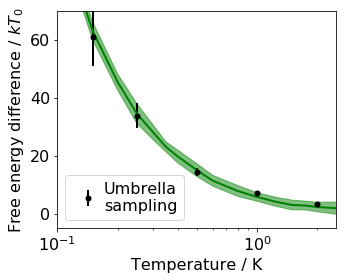

In [43]:
plt.figure(figsize=(5, 4))
dFs12arr = np.array(dFs12)
means = dFs12arr[:, -20:].mean(axis=(1))
uncertainties = dFs12arr[:, -20:].std(axis=(1))
plt.plot(temperatures_analysis, means, color='green', linewidth=2)
plt.fill_between(temperatures_analysis, means-2.0*uncertainties, means+2.0*uncertainties, color='green', alpha=0.5)
plt.errorbar(distinct_temperatures_US, -means_US, 2.0*stds_US,
             color='black', elinewidth=2, linewidth=0, marker='.', markersize=10, label='Umbrella\nsampling')
plt.semilogx()
plt.xlim(0.1, 2.5)
plt.ylim(-5, 70)
plt.xlabel('Temperature / K')
plt.ylabel('Free energy difference / $kT_0$')
plt.legend(loc=3, frameon=True, handletextpad=0)
plt.savefig(paper_dir + 'figs/particles/free_energy_2BGs.pdf', bbox_inches='tight', transparent=True)

(20, 100)

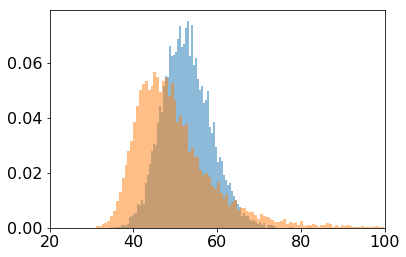

In [36]:
_, sample_x_bg1, _, energies_x_bg1, _ = bg1.sample(nsample=10000)
plt.hist(model.energy(traj_closed_train[:10000]), 100, density=True, alpha=0.5);
plt.hist(energies_x_bg1[energies_x_bg1<100], 100, density=True, alpha=0.5);
plt.xlim(20, 100)

(20, 100)

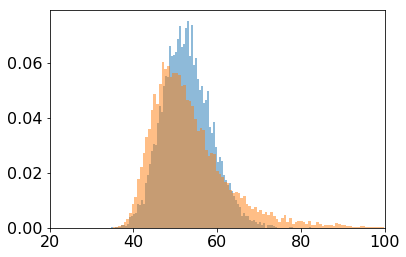

In [37]:
_, sample_x_bg2, _, energies_x_bg2, _ = bg2.sample(nsample=10000)
plt.hist(model.energy(traj_closed_train[:10000]), 100, density=True, alpha=0.5);
plt.hist(energies_x_bg2[energies_x_bg2<100], 100, density=True, alpha=0.5);
plt.xlim(20, 100)